In [1]:
import sys
sys.path.append('..')
from d2l import torch as d2l
import torch
from torch import nn
batch_size, max_window_size, num_noise_words = 512, 5, 5


In [2]:
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

In [3]:
names = ['centers', 'contexts_negateivs', 'masks', 'labels']
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negateivs shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [4]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [5]:
x = torch.tensor([[1, 2, 3,], [4, 5, 6]])
embed(x)

tensor([[[ 0.3818, -0.7082,  0.0597, -1.9313],
         [-0.8209,  1.6184,  0.4777,  1.0715],
         [-0.2561, -0.0168, -1.8169, -0.1772]],

        [[ 0.2183,  0.0480, -1.5399,  2.1031],
         [ 2.3165,  1.5570,  0.3393,  0.2843],
         [-1.0423, -0.8965,  0.0579, -0.5885]]], grad_fn=<EmbeddingBackward>)

In [6]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [7]:
skip_gram(torch.ones((2, 1), dtype=torch.long), torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [8]:
class SigmoidBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [9]:
pred = torch.tensor([[.5]*4]*2)
label = torch.tensor([[1., 0., 1.0, 0.]]*2)
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask)

tensor([0.7241, 0.3620])

In [10]:
loss(pred, label, mask) / mask.sum(axis = 1) * mask.shape[1]

tensor([0.7241, 0.7241])

In [11]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab), 
                                    embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                    embedding_dim=embed_size))

In [12]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weight(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])
    metric = d2l.Accumulator(2)

    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask) / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1], ))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.373, 126447.5 tokens/sec on cuda:0


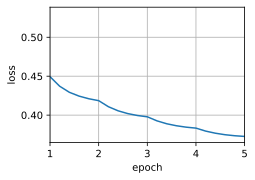

In [13]:
lr, num_epoch = 0.01, 5
train(net, data_iter, lr, num_epoch)

In [14]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) +1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk:
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.idx_to_token[i]}')

get_similar_tokens('chip', 4, net[0])

cosine sim=1.000: chip
cosine sim=0.566: intel
cosine sim=0.480: computers
cosine sim=0.476: microprocessor
cosine sim=0.446: user
